# Updated Pipeline for joining ERA/MODIS

In Notebook `02.Join_MODIS_with_ERA_NetCDF` we were finding for every ERA datapoint the single nearest MODIS datapoint, and then filtering by some tolerance. i.e. if the nearest MODIS datapoint is 1 bazillion miles away from the ERA point, we dont want to count that as a match. Exactly what this tolerance should be is open for discussion, but we set it at 50 km.



An alternate way to do this matching as shown in this notebook is to reverse this process and say:

* For every MODIS point, what is the nearest ERA datapoint?
* Filter by some tolerance
* Groupby for each ERA lat/long point


# Dictionaries, configs, imports

In [3]:
import xarray as xr
import rioxarray
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.neighbors import NearestNeighbors


#Path to ERA data
era_folder = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw'




# Functions

In [48]:





def get_era_data(date : str,
                 utc_hour : str,
                 field : str,
                 bounds : dict,
                 source: str):

    """Function to load hourly slice of ERA data 
       Additional filtering by max/min longitude, read from matching MODIS file
    """
        
    #Load the data
    month = '_'.join(date.split('-')[:-1])
    
    if source == 'ERA_skin':
        name = '_skin_'
    if source == 'ERA_sfc':
        name = '_'
        
    utc_0hour = f'{utc_hour:02}'
    fname = f'{era_folder}/{source}/NetCDF/{date}T{utc_0hour}:00:00.000000000.nc'
    ds_era = xr.open_dataset(fname)
    
        
    #Grab correct field
    if field is not None:
        da = ds_era[field]
    else:
        da = ds_era
    
     # Also filter by latitude/longtiude
    longitude_filter = (da.longitude > bounds['longitude_min']) & (da.longitude < bounds['longitude_max'])
    latitude_filter =  (da.latitude > bounds['latitude_min']) & (da.latitude < bounds['latitude_max'])
    
  
    da_filtered = da.where(longitude_filter & latitude_filter,drop=True)

    #Explictley close the file
    ds_era.close()
    
    return da_filtered
    



    
def filter_out_sea(ds : xr.Dataset):
    
    """
    Use lsm variable to filter out ocean values, retaining only land values
    Returns a pandas dataframe
    """
    
    df = ds.to_dataframe().reset_index()
    df_land = df.loc[df['lsm'] > 0.5]
    
    
    return df_land
    
    
    

import faiss

def faiss_knn(database,query):
    
    """
    Use faiss library (https://github.com/facebookresearch/faiss) for fass k-nearest neighbours on GPU
    
    Note that the nearness is an L2 (squared) norm on the lat/long coordinates, rather than a haversine metric
    """
    
    #Database
    xb = database[["latitude", "longitude"]].to_numpy().astype('float32')
    xb = xb.copy(order='C') #C-contigious
    
    #Query
    xq = query[["latitude", "longitude"]].to_numpy().astype('float32') 
    xq = xq.copy(order='C')
    
    #Create index
    d = 2                            # dimension
    res = faiss.StandardGpuResources()
    index_flat = faiss.IndexFlatL2(d) #index
    gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index_flat) # make it into a gpu index
    gpu_index_flat.add(xb)  
    
    #Search
    k = 1                          # we want to see 1 nearest neighbors
    distances, indices = gpu_index_flat.search(xq, k)
    

    #Combine into a single df with all data
    df = query.reset_index().join(database.iloc[indices.flatten()].reset_index(), lsuffix='_GOES',rsuffix='_ERA')
    df['L2_distance'] = distances
    df['GOES_idx'] = indices
    df['H_distance'] = haver(df['latitude_GOES'],df['longitude_GOES'],df['latitude_ERA'],df['longitude_ERA']) #Haversine distance
    
    #Filter out any large distances
    tolerance = 50 #km
    df_filtered = df.query('H_distance < %.9f' % tolerance)
    


    #Group it. Each ERA point has a bunch of MODIS points. Group and average
    df_grouped = df_filtered.groupby(['latitude_ERA','longitude_ERA'],as_index=False).mean()

    


    
    
    return df_grouped













def haver(lat1_deg,lon1_deg,lat2_deg,lon2_deg):
    
    """
    Given coordinates of two points IN DEGREES calculate the haversine distance
    """
    
    #Convert degrees to radians
    lat1 = np.deg2rad(lat1_deg)
    lon1 = np.deg2rad(lon1_deg)
    lat2 = np.deg2rad(lat2_deg)
    lon2 = np.deg2rad(lon2_deg)


    #...and the calculation
    delta_lat = lat1 -lat2
    delta_lon = lon1 -lon2
    Re = 6371 #km
    Z = np.sin(delta_lat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(delta_lon/2)**2
    H = 2*Re*np.arcsin(np.sqrt(Z)) #Haversine distance in km
    return H

    
    
    
    

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)
        
        
        
        

def plot_map(ds,x,y,q): #slow plotting function

    #Takes a ds, converts to pandas df
    
    if isinstance(ds, pd.DataFrame):
        df = ds
    else:
        df = ds.to_dataframe().reset_index()#.dropna()
        
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[x], df[y]))
    
    #Plot the world
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax=world.boundary.plot(figsize=(24,12))
    
    gdf.plot(ax=ax,column=q,cmap='plasma',markersize=1,legend=True)
    
    plt.show()
    
    
    
    
    
    

    
    
    


In [36]:
#Set the parameters
date = '2018-04-19'


# GOES

In [37]:
#Load the GOES data
GOES_df = pd.read_csv("/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/GOES.csv") 

In [44]:
GOES_df

,Unnamed: 0,longitude,latitude,temperature,time
0,14652,-77.519860,69.998040,260.06750,2018-04-19 17:06:01.574386944
1,14653,-77.222786,69.994140,260.06250,2018-04-19 17:06:01.574386944
2,14654,-76.926100,69.992410,260.34000,2018-04-19 17:06:01.574386944
3,14660,-75.148060,69.984540,261.12000,2018-04-19 17:06:01.574386944
4,14661,-74.851910,69.984540,261.18000,2018-04-19 17:06:01.574386944
...,...,...,...,...,...
121280,1148512,-59.120050,-64.453410,255.34250,2018-04-19 17:06:01.574386944
121281,1149587,-61.662956,-64.656296,256.51500,2018-04-19 17:06:01.574386944
121282,1149590,-60.916656,-64.693080,258.47250,2018-04-19 17:06:01.574386944
121283,1150671,-61.974274,-64.982120,251.74750,2018-04-19 17:06:01.574386944


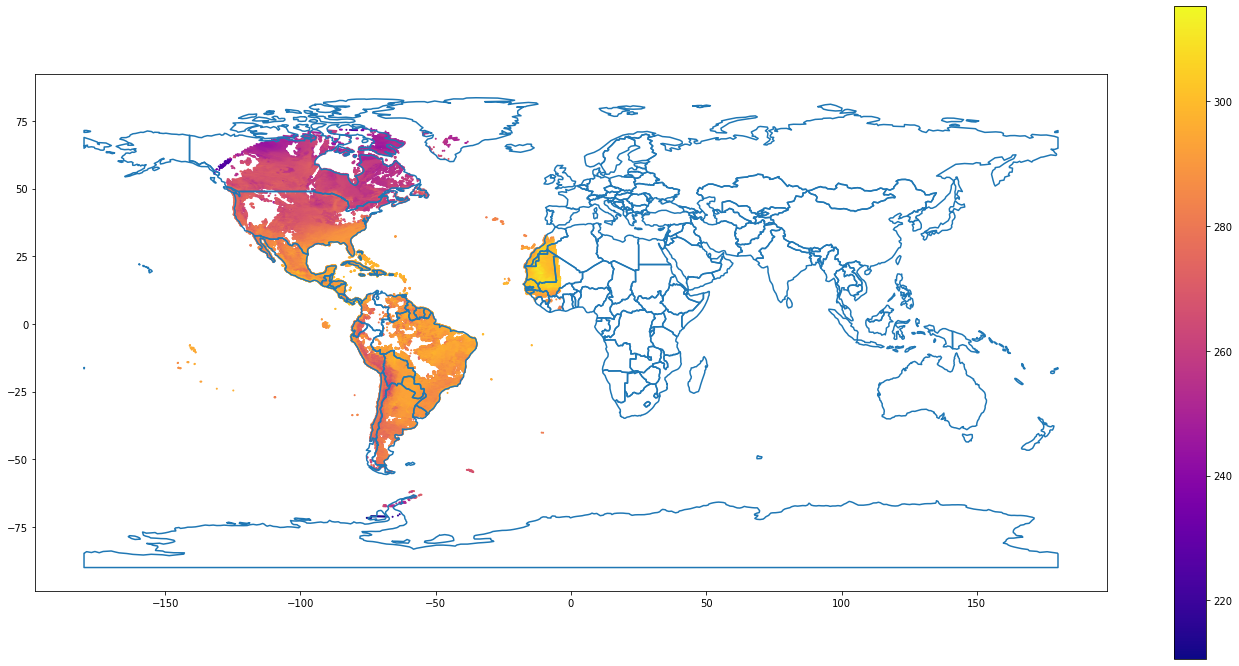

In [10]:
plot_map(GOES_df,'longitude','latitude','temperature')

# ERA

In [45]:

utc_hour = 17
#ERA
delta = 1.0
bounds = {"latitude_min" :GOES_df.latitude.min()-delta,
          "latitude_max" :GOES_df.latitude.max()+delta,
          "longitude_min":GOES_df.longitude.min()-delta,
          "longitude_max":GOES_df.longitude.max()+delta
          }
fields = None #['t2m','v10'] #'None' selects all data variables. Selecting > 1 field returns a dataset rather than a data array
ERA_sfc = get_era_data(date = date,utc_hour=utc_hour,field=fields,bounds=bounds,source='ERA_sfc')
ERA_skin = get_era_data(date = date,utc_hour=utc_hour,field=fields,bounds=bounds,source='ERA_skin')
ERA = xr.merge([ERA_sfc, ERA_skin])
ERA_df_land = filter_out_sea(ERA)



In [50]:
ERA_df_land

,values,sp,msl,u10,v10,t2m,latitude,longitude,number,time,...,sdfor,z,sd,sdor,isor,anor,slor,d2m,lsm,fal
35,35,97889.59375,101000.00,2.280975,-1.832672,248.540726,70.960137,-117.600000,0,2018-04-19 17:00:00,...,39.120056,2276.792725,0.082354,75.429077,0.635685,-0.407843,0.008917,245.508041,0.991007,0.676539
36,36,96252.59375,100970.00,1.904022,-1.010406,248.126663,70.960137,-116.800000,0,2018-04-19 17:00:00,...,38.543701,3482.831787,0.084717,79.251587,0.576056,0.522598,0.009828,245.176010,0.997943,0.655985
37,37,96002.59375,100954.50,0.924530,0.102875,248.333694,70.960137,-116.000000,0,2018-04-19 17:00:00,...,50.124817,3662.925537,0.075378,100.790405,0.502674,-1.559908,0.013692,245.328354,0.991687,0.611262
38,38,96025.59375,100955.25,0.623749,0.187836,248.136429,70.960137,-115.200000,0,2018-04-19 17:00:00,...,38.051086,3643.652100,0.072849,74.840454,0.537747,0.738718,0.010705,244.752182,0.999938,0.586207
39,39,96765.59375,100956.50,1.192108,-0.983063,248.157913,70.960137,-114.400000,0,2018-04-19 17:00:00,...,22.675720,3083.284912,0.069684,45.378906,0.790816,-0.222495,0.005099,244.634995,0.999388,0.574778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200643,200643,83094.59375,97872.75,0.016327,0.756195,262.530945,-65.901600,-63.333333,0,2018-04-19 17:00:00,...,130.739014,12508.957031,10.000000,252.645264,0.611208,1.477271,0.038902,261.545166,1.000000,0.850001
200644,200644,92557.59375,98078.75,0.227264,2.665375,263.286804,-65.901600,-62.666667,0,2018-04-19 17:00:00,...,109.976990,4391.785156,10.000000,173.941528,0.479922,1.488638,0.028015,260.951416,0.999868,0.850001
200645,200645,97627.59375,98108.75,2.527069,6.512054,263.165710,-65.901600,-62.000000,0,2018-04-19 17:00:00,...,19.783630,369.929443,10.000000,75.264648,0.529287,-0.626108,0.007554,260.254150,0.999979,0.850001
200646,200646,97239.59375,98068.25,4.042694,6.222015,262.753601,-65.901600,-61.333333,0,2018-04-19 17:00:00,...,51.783508,637.726318,10.000000,49.927368,0.322247,0.426332,0.012339,260.420166,1.000000,0.850001


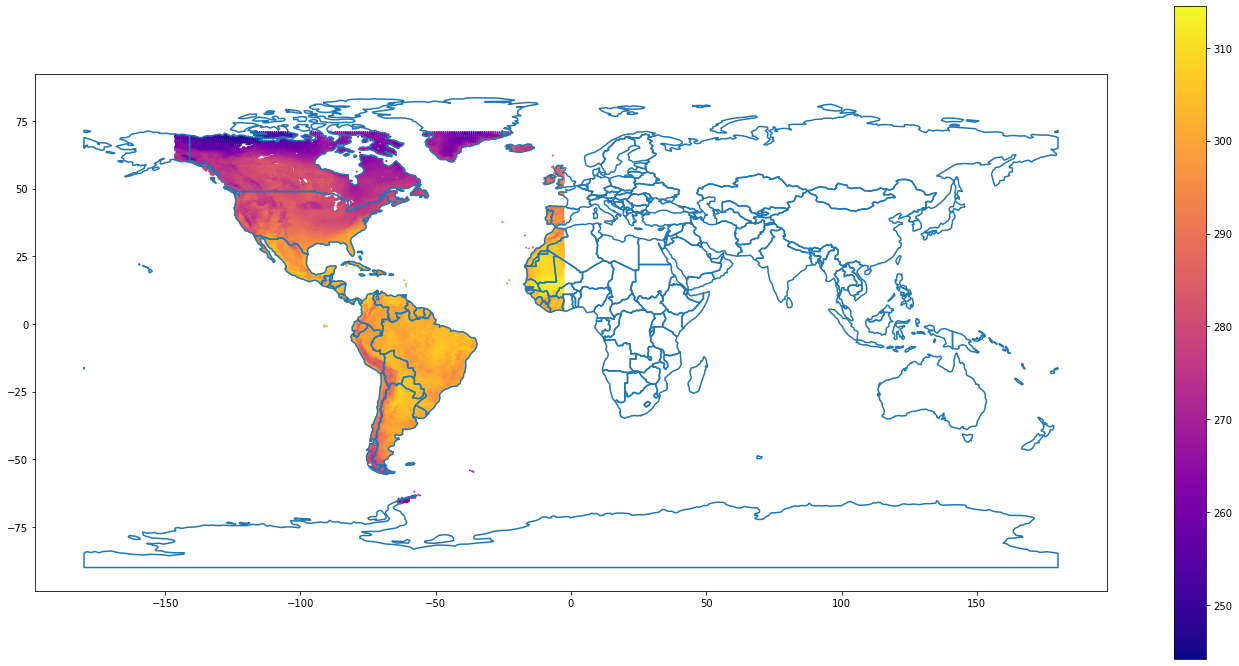

In [51]:
plot_map(ERA_df_land,'longitude','latitude','t2m')

# Finding a match


By virtue of the time slices we have performed, the data is already matched in time.

We now need to match in space. i.e. for each gridpoint in ERA we want to find the closest match in MODIS. We use the Haversine distance as our closeness metric.

We also need to enforce a tolerance to filter out matches which are not sufficently close.

This process returns a pandas df of the ERA data joined with the matching rows in MODIS. This provides a corresponding MODIS temperature for each entry (where available) in ERA. We also return the Haversine distance between the matches. Perhaps this could be used as some kind of error... 

Example:

In [52]:
%%time
df = faiss_knn(ERA_df_land,GOES_df.dropna())

CPU times: user 137 ms, sys: 120 ms, total: 257 ms
Wall time: 256 ms


In [53]:
display(df)

,latitude_ERA,longitude_ERA,index_GOES,Unnamed: 0,longitude_GOES,latitude_GOES,temperature,index_ERA,values,sp,...,sdor,isor,anor,slor,d2m,lsm,fal,L2_distance,GOES_idx,H_distance
0,-65.058510,-61.875,121283.5,1150671.5,-61.848792,-64.988300,251.697495,199964.0,199964.0,90391.59375,...,266.998169,0.478916,-0.751755,0.050962,265.683838,0.999502,0.850001,0.021240,45447.0,9.879665
1,-64.777481,-61.875,121281.0,1149587.0,-61.662956,-64.656296,256.515000,199734.0,199734.0,87512.59375,...,483.759766,0.564005,-0.831033,0.081151,266.556885,0.944065,0.850001,0.059570,45441.0,16.822119
2,-64.777481,-60.625,121282.0,1149590.0,-60.916656,-64.693080,258.472500,199736.0,199736.0,93289.59375,...,186.985718,0.554106,-0.881660,0.034477,264.416260,1.000000,0.850001,0.091797,45443.0,16.723075
3,-64.496451,-60.000,121279.0,1148509.0,-59.871690,-64.412636,255.512500,199507.0,199507.0,92810.59375,...,347.765747,0.275660,-0.595376,0.055795,265.117432,0.999913,0.850001,0.023438,45438.0,11.167402
4,-64.215421,-60.625,121274.0,1147422.0,-60.320133,-64.060240,254.302490,199276.0,199276.0,85701.59375,...,312.749756,0.804843,0.672787,0.043594,267.326416,0.986648,0.850001,0.116211,45429.0,22.724587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23979,69.836018,-54.000,56.5,16901.5,-54.092624,69.924110,269.620000,852.0,852.0,90804.59375,...,220.940063,0.374528,0.601480,0.053900,259.685791,0.998675,0.667353,0.046875,400.0,12.483736
23980,70.117048,-96.000,27.5,16762.5,-96.261032,69.953982,256.938750,604.0,604.0,99136.59375,...,17.450562,0.591270,0.426120,0.003194,257.633057,0.981437,0.791544,0.125000,272.0,21.743842
23981,70.117048,-77.250,1.0,14653.0,-77.222915,69.994863,260.156667,629.0,629.0,99527.59375,...,72.246582,0.495178,-0.164707,0.013811,257.338135,0.993665,0.660273,0.074870,289.0,16.318461
23982,70.117048,-75.000,3.5,14660.5,-74.999985,69.984540,261.150000,632.0,632.0,97526.59375,...,61.481812,0.277606,0.381270,0.008872,257.427979,0.994567,0.654368,0.039551,292.0,15.768786


In [54]:
display(df[['latitude_ERA','longitude_ERA','latitude_GOES','longitude_GOES','t2m','temperature','H_distance']])

,latitude_ERA,longitude_ERA,latitude_GOES,longitude_GOES,t2m,temperature,H_distance
0,-65.058510,-61.875,-64.988300,-61.848792,266.398132,251.697495,9.879665
1,-64.777481,-61.875,-64.656296,-61.662956,268.439148,256.515000,16.822119
2,-64.777481,-60.625,-64.693080,-60.916656,266.320007,258.472500,16.723075
3,-64.496451,-60.000,-64.412636,-59.871690,267.632507,255.512500,11.167402
4,-64.215421,-60.625,-64.060240,-60.320133,267.878601,254.302490,22.724587
...,...,...,...,...,...,...,...
23979,69.836018,-54.000,69.924110,-54.092624,266.962585,269.620000,12.483736
23980,70.117048,-96.000,69.953982,-96.261032,259.556335,256.938750,21.743842
23981,70.117048,-77.250,69.994863,-77.222915,263.083679,260.156667,16.318461
23982,70.117048,-75.000,69.984540,-74.999985,265.216492,261.150000,15.768786


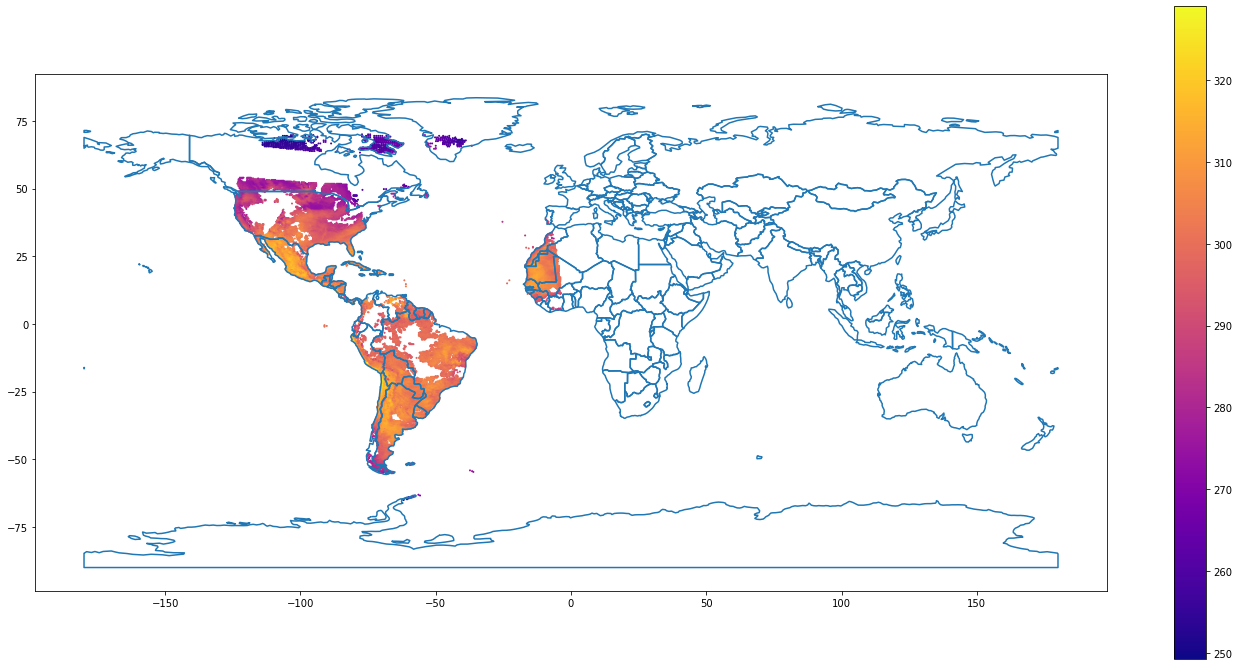

In [55]:
plot_map(df,'longitude_ERA','latitude_ERA','temperature')

In [56]:
df['error_ERA'] = df.temperature - df.t2m

In [57]:
df['error_ERA']

0       -14.700637
1       -11.924148
2        -7.847507
3       -12.120007
4       -13.576111
           ...    
23979     2.657415
23980    -2.617585
23981    -2.927013
23982    -4.066492
23983     1.862649
Name: error_ERA, Length: 23984, dtype: float64

In [58]:
import matplotlib.colors as mc
import matplotlib.colorbar as cb  
def plot_error_map(df,z,vmin,vmax,cmap):
    
    #Get all data as vectors
    x = df.longitude_ERA
    y = df.latitude_ERA
    z1 = df[z]
    
    #Scatter plot it
    # init the figure
    fig,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},figsize=(30, 20))

    
    norm = mc.Normalize(vmin=vmin, vmax=vmax)

    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    
    
    sc = ax.scatter(x, y,
               s=1,
               c=cmap(norm(z1)),
               linewidths=1, alpha=.7
               )

    ax.set_title(z)
    
    plt.show()

Mean error: 3.5533461075479256
Median error: 2.189055175781249


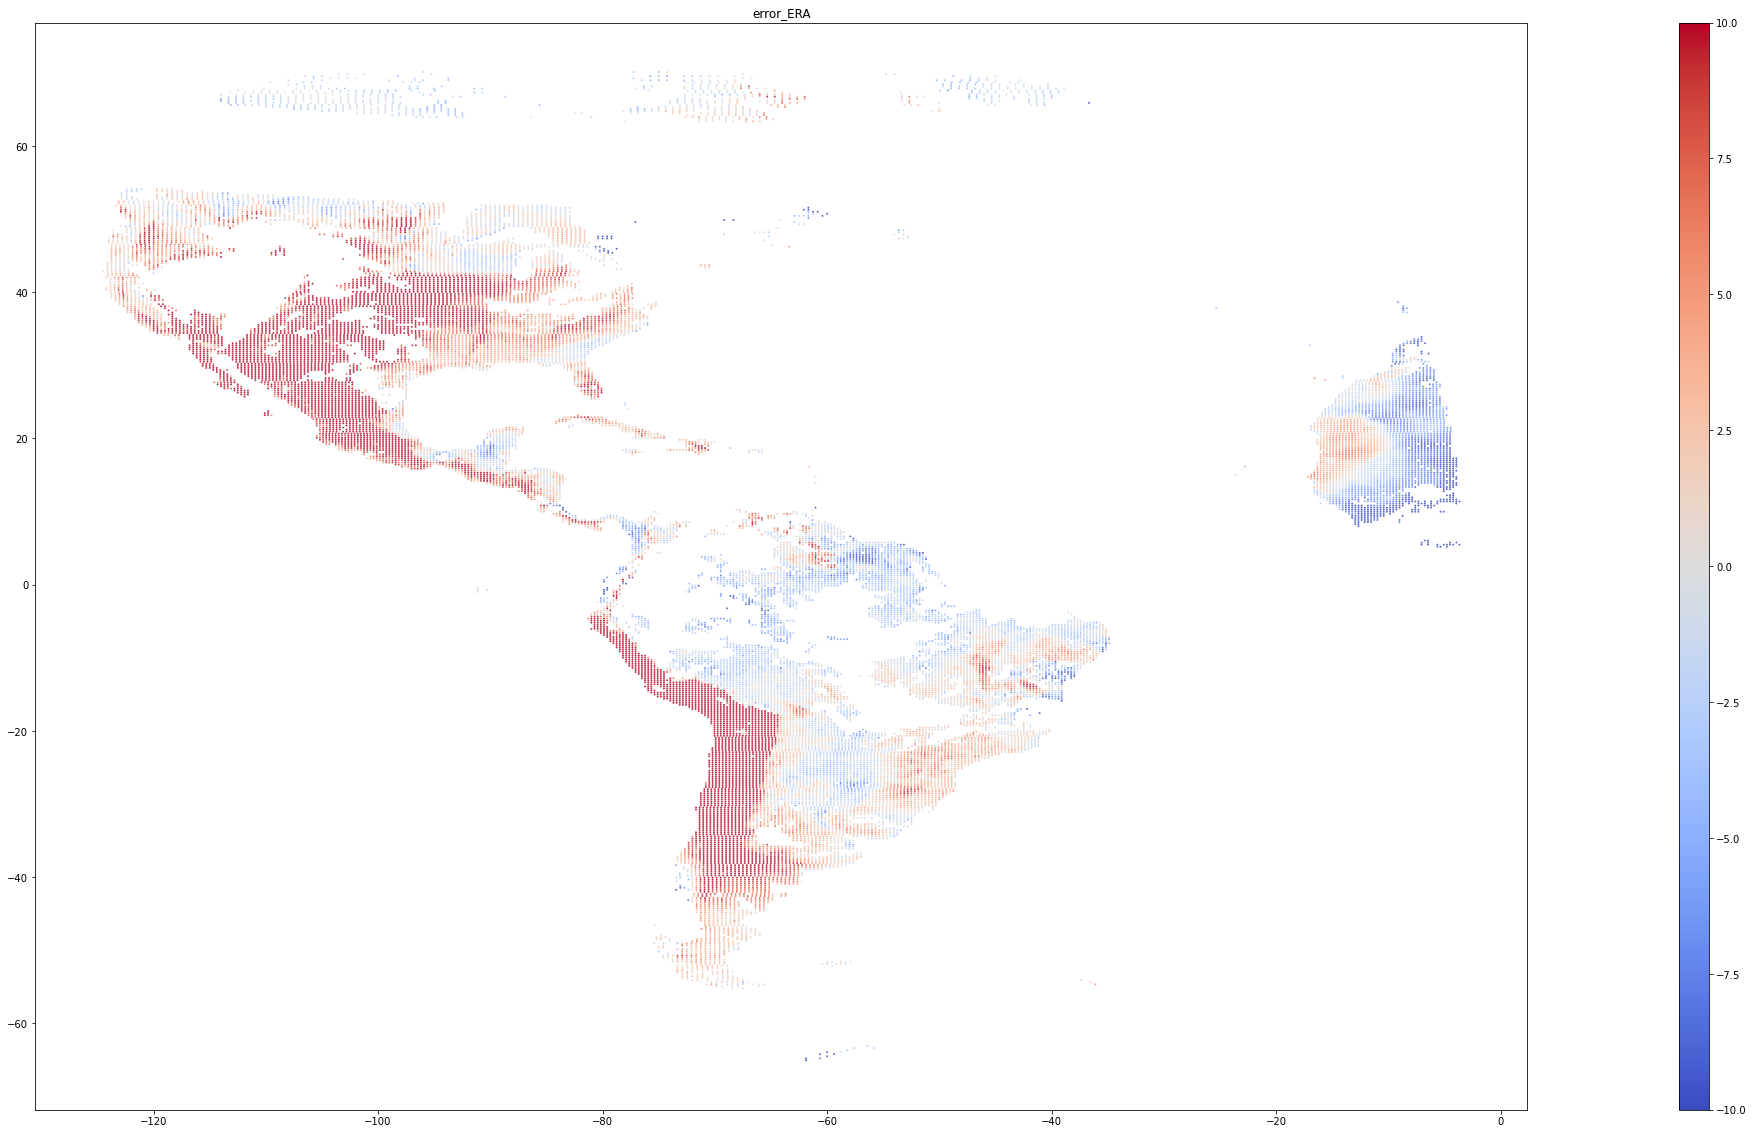

In [59]:

print ('Mean error:',df.error_ERA.mean())
print ('Median error:',df.error_ERA.median())
plot_error_map(df,'error_ERA',vmin=-10,vmax=10,cmap = plt.cm.coolwarm)



MODIS:


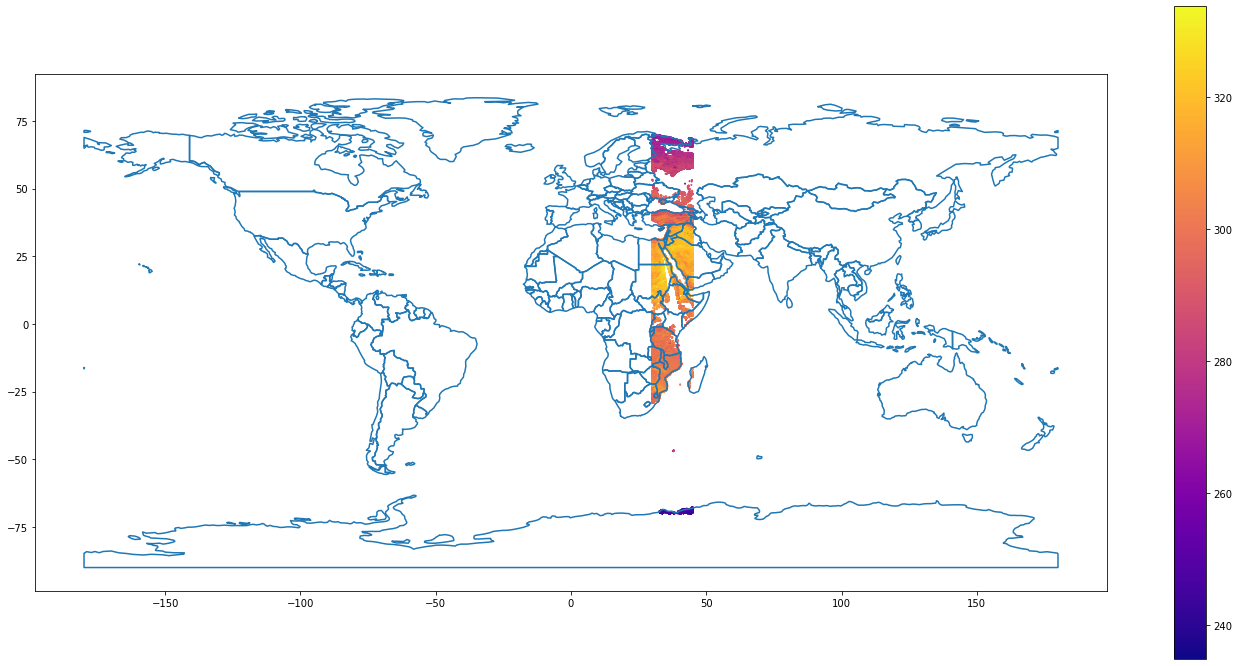

ERA land:


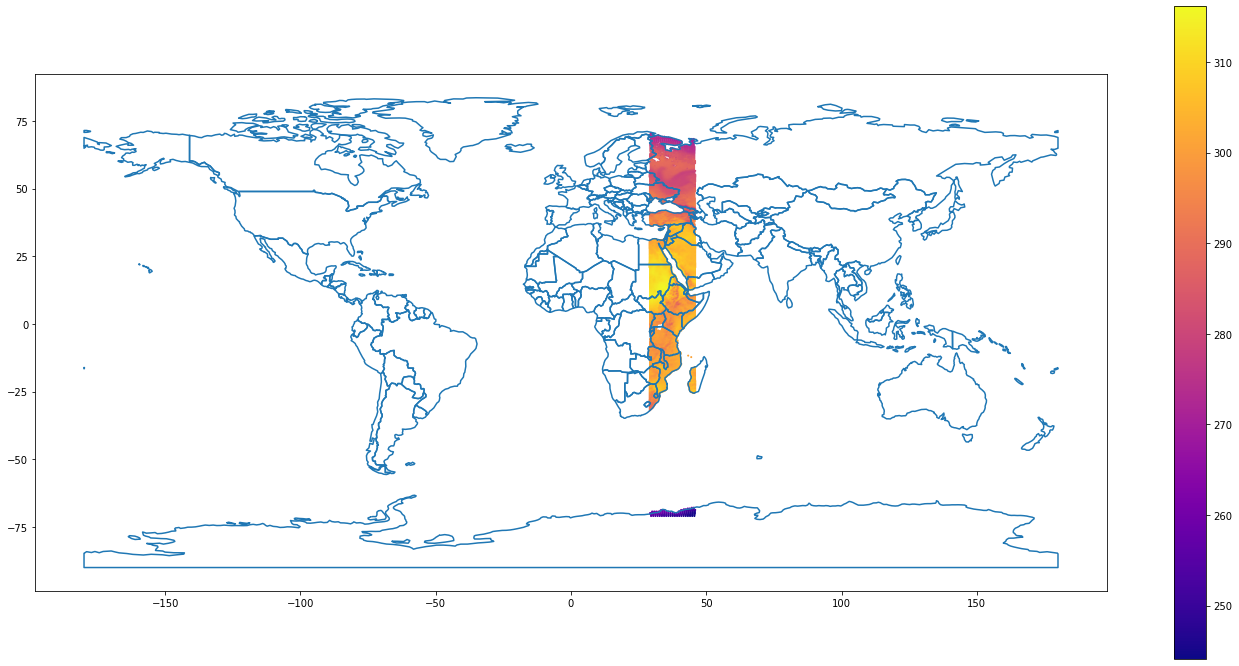

Matched, temperature:


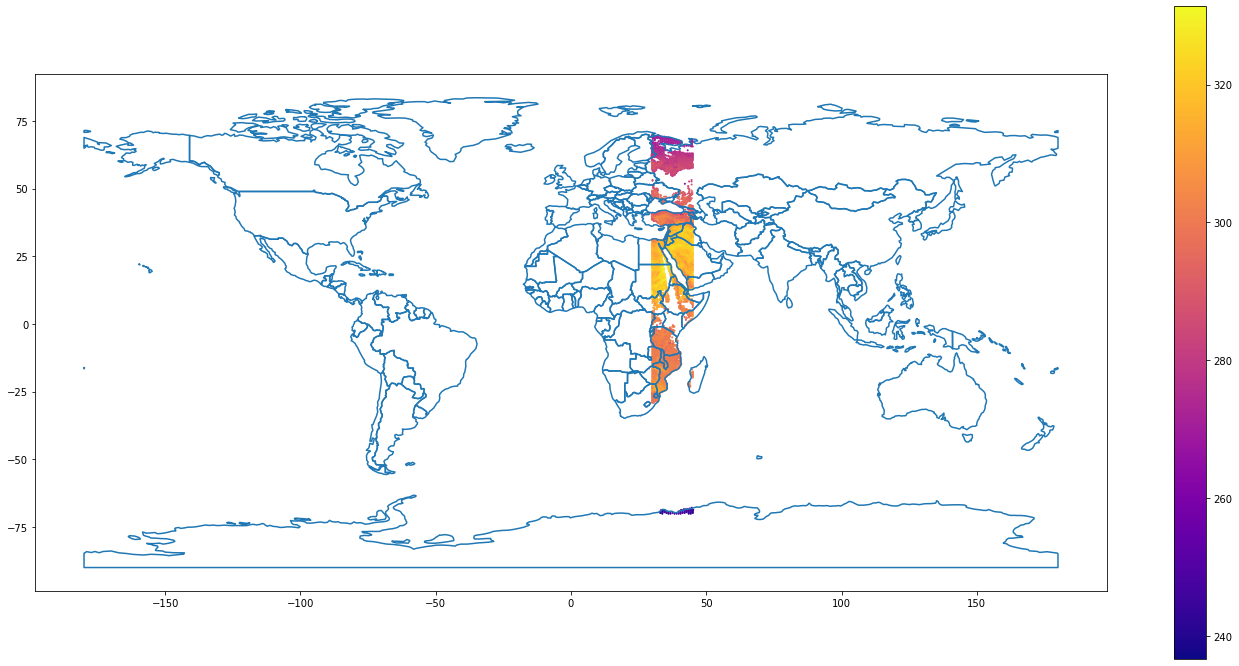

Matched, distance:


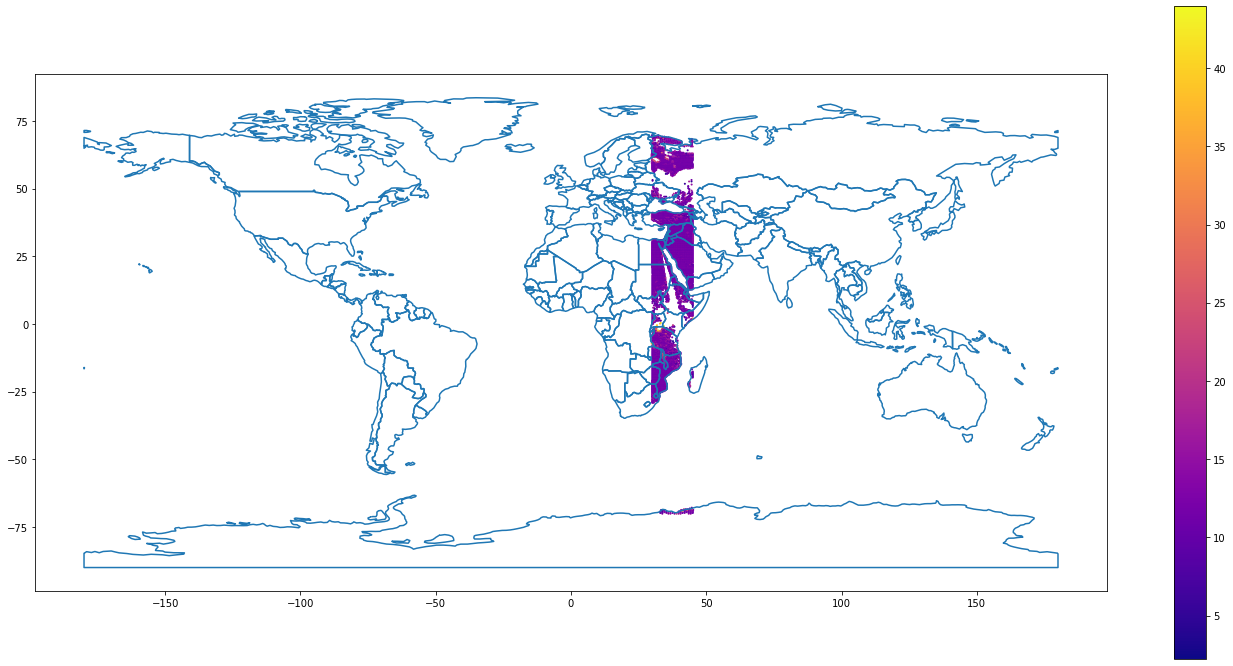

In [11]:
print('MODIS:')
plot_map(MODIS_df,'longitude','latitude','MODIS_LST')
print('ERA land:')
plot_map(ERA_df_land,'longitude','latitude','t2m')
print('Matched, temperature:')
plot_map(df,'longitude_ERA','latitude_ERA','MODIS_LST')
print('Matched, distance:')
plot_map(df,'longitude_ERA','latitude_ERA','H_distance')

# Time tests


In [2]:
def pipeline(date,utc_hour,satellite,latitude_bound,ERA_fields):

    # MODIS data
    MODIS = get_satellite_slice(date,utc_hour,satellite,latitude_bound)
    
    if not isinstance(MODIS,xr.DataArray):
        return pd.DataFrame() #If there is no appropriate data it just returns a 0. We then create an empty pd df so no matches will be found
    
    #Make MODIS ds a df
    MODIS_df = MODIS.to_dataframe(name='MODIS_LST').reset_index()
    
    #ERA data
    delta = 1.0 #Enveloping box.
    bounds = {"latitude_min" :MODIS.latitude.data.min()-delta,
          "latitude_max" :MODIS.latitude.data.max()+delta,
          "longitude_min":MODIS.longitude.data.min()-delta,
          "longitude_max":MODIS.longitude.data.max()+delta
          }
    
    ERA_sfc = get_era_data(date, utc_hour, field=ERA_fields,bounds=bounds,source='ERA_sfc')
    ERA_skin = get_era_data(date, utc_hour, field=ERA_fields,bounds=bounds,source='ERA_skin')
    ERA = xr.merge([ERA_sfc, ERA_skin])
    
    ERA_df_land = filter_out_sea(ERA) #just the land values
    

    #Explicitly deallocate everything
    MODIS.close()
    MODIS = None
    ERA_sfc.close()
    ERA_skin.close()
    ERA_sfc = None
    ERA_skin = None
    
    
    #Combine
    df_sk = faiss_knn(ERA_df_land,MODIS_df.dropna())
    
    return df_sk       
        

In [43]:

from datetime import timedelta, date

In [167]:
%%time

#Parameters
start_date = date(2018, 1, 2)
end_date   = date(2018, 1, 2)
dates = daterange(start_date,end_date)
hours = np.arange(0,24)


satellite='aquaDay'
latitude_bound=70
ERA_fields = None 



#Path for where to ouput saved files
IO_path = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/joined_ML_data/'


for dt in dates:
    d = dt.strftime("%Y-%m-%d")
    for h in hours:
        fname = satellite + '_'+str(d)+'_'+str(h)+'H_'+str(latitude_bound)+'L_+T.pkl'
        print(fname)
        df = pipeline(d,h,satellite,latitude_bound,ERA_fields)
        #df.to_pickle(IO_path+fname)



aquaDay_2018-01-02_0H_70L_+T.pkl
2018-01-01
aquaDay_2018-01-02_1H_70L_+T.pkl
2018-01-01
aquaDay_2018-01-02_2H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_3H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_4H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_5H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_6H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_7H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_8H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_9H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_10H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_11H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_12H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_13H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_14H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_15H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_16H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_17H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_18H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_19H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_20H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_21H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_2

---

# Appendix

### We could also use an Euclidean norm:

In [ ]:
ERA_df_land['latitude_rad'] = np.deg2rad(ERA_df_land['latitude'])
ERA_df_land['longitude_rad'] = np.deg2rad(ERA_df_land['longitude'])

ERA_df_land['coordinate_x'] = np.cos(ERA_df_land['latitude_rad']) * np.cos(ERA_df_land['longitude_rad'])
ERA_df_land['coordinate_y'] = np.cos(ERA_df_land['latitude_rad']) * np.sin(ERA_df_land['longitude_rad'])
ERA_df_land['coordinate_z'] = np.sin(ERA_df_land['latitude_rad'])

### t2m vs MODIS_LST